# Ferromagnetismo

In [3]:
import utils
import numpy as np
import matplotlib.pyplot as plt

### Energía promedio

$$
\begin{equation}
    <E> = \frac{1}{MCS_{max} - t_o} \sum_{t_o + 1}^{MCS_{max}} E_k
\end{equation}
$$


In [9]:
# numero cuantico m, m = -J,-J+1,-J+2,...,J-1,J
m_numbers = lambda J: np.arange(-J, J+1)


def build_system(SIZE, m):
    """Microestado inicial aleatorio"""
    spin =  np.random.choice(m, size=(SIZE, SIZE))
    return spin


def metropolis(config,J,B,T):

    """ Algoritmo de metropolis 
    config = Configuracion del sistema
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    Retorna la confguración del sistema y la energía
    """

    E = 0 #Energía
    L = len(config) # Tamaño 
    for i in range(L):
        for j in range(L):

            conf_i = config[i, j] 

            # sitios vecinos
            conf_j = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L] 
            
            # Energia inicial del sitio
            Ei = -J*np.dot(conf_i,conf_j) - conf_i*B 

            # Fluctuar el espín del sitio seleccionado
            conf_trial = config[i, j] * -1

            # Calculo de Energia luego de perturbar el vector a evaluar
            Ef = -J*np.dot(conf_trial,conf_j) - conf_trial*B 
            
            # Diferencia entre energia luego de perturbar el sitio y energia inicial
            Delta_E = Ef - Ei 

            # Criterio de montecarlo, si minimiza la energia permitir la perturbacion
            if Delta_E <= 0 or np.random.rand() <= np.exp(-Delta_E/T): 
                conf_i = conf_trial
                E += Delta_E

            # almacena la configuracion que cumple la condición
            config[i, j] = conf_i 

    return config, E


In [10]:
def montecarlo_step(config,J,B,T):
    '''
    Funcion que permite implementar la funcion de montecarlo, calculo de energia total, magnetizacion promedio
    config = Configuracion a evolucionar.
    m = Lista de numero cuantico m
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura 
    '''
    # número máximo de pasos de montecarlo
    MCSmax = 100

    # Energía
    Energy = 0 
    Energy2 = 0

    # Magnetización
    Magnetiz = 0

    # criterio de estabilidad en la medida
    to = int(MCSmax/2)

    for mcs in range(MCSmax):
        # evolución del sistema
        config, energy = metropolis(config,J,B,T) 
        
        if mcs > to: 
            Magnetiz += np.sum(config) # calculo de magnetizacion
            Energy += energy
            Energy2 += energy**2
    
    Magnetiz = Magnetiz/(MCSmax-to) # Magnetizacion promedio
    Energy = Energy/(MCSmax-to)     # Energía promedio
    Energy2 = Energy2/(MCSmax-to)
    #utils.plot_snapshots(config, f"{T}")

    return Magnetiz, Energy, Energy2



def main(s,J,B,T):

    """
    Función pincipal que ejecuta el algoritmo de Metropolis
    para distintos valores de temperatura
    Retorna un array de la magnetización y energía promedio
    s = Spin
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    """

    SIZE=100

    m = m_numbers(s)

    # Configuracion inicial    
    config_i = build_system(SIZE, m) 
    
    # Magnetizacion
    M = [] 

    # Energía
    E = [] 
    E2 = [] 

    # recorre los valores de temperatura 
    for i,t in enumerate(T): 

        # barra de progreso
        utils.progressBar(i+1, len(T))

        # evoluciona el sistema 
        Magnetiz, Energy, Energy2 = montecarlo_step(config_i, J, B, t) 
        
        M.append(Magnetiz)
        E.append(Energy)
        E2.append(Energy2)
        
    
    return np.array(M), np.array(E), np.array(E2)


## Transición de fase

Capacidad calorífica:

\begin{equation}
    C_v = \frac{\langle E^2 \rangle - \langle E \rangle^2}{\kappa_B T^2}
\end{equation}

Temperatura crítica:

\begin{equation}
k_B  T_c = \frac{2J}{\ln\left(1 + \sqrt{2}\right)} 
\end{equation}

In [11]:
def phaseTransition():

    """
    Ejecuta el algoritmo principal con distintos 
    valores de temperatura. Guarda archivos con temperatura 
    vs. Magnetización y temperatura vs. energía
    """

    B=0

    # Temperatura
    T  = np.linspace(1.5,0.001,200)
    M, E, E2 = main(s=1/2, J=1, B=B, T=T)

    utils.save_lists_as_columns(f"MvsT.txt", T, M)
    utils.save_lists_as_columns(f"CVvsT.txt", T, np.column_stack((E, E2)))



In [12]:
phaseTransition()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [27]:
def graph(itype):

    """Lee los resultado en archivos .txt y reliza las gráficas"""
    
    data = np.loadtxt(f"{itype}.txt").T
    
    if itype == "MvsT":
        max = np.max(data[1])
        plt.ylabel(f"<M>/M_max")
        plt.plot(data[0], data[1]/max, '.', alpha=0.5, c="b")


    if itype == "CVvsT":
        # Capacidad calorifica: Cv = (E2 - E**2) / (T**2)
        T = data[0]
        E = data[1]
        E2 = data[2]
        plt.ylabel(f"Cv")
        plt.plot(T, (E2 - E*E) / (100*100*(T**2)), '.', alpha=0.5, c="b")

    plt.xlabel("T")
    plt.grid()

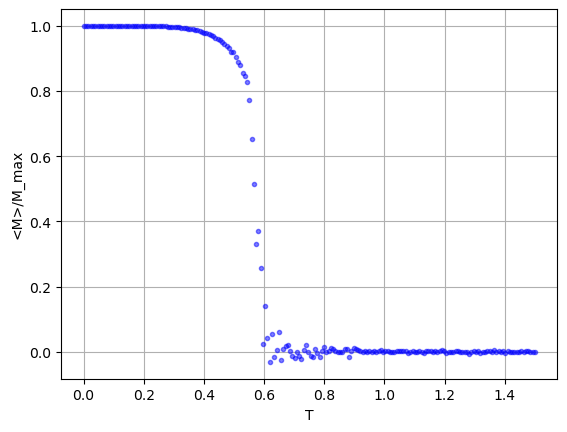

In [34]:
graph(itype="MvsT")

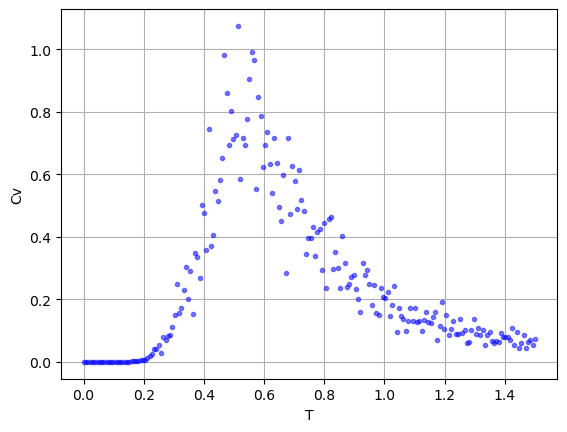

In [28]:
graph(itype="CVvsT")

## Histéresis

In [ ]:
def hysteresis():

    """
    Ejecuta el algoritmo principal para verificar 
    el fenómeno de histéresis para un ferromagneto tipo Ising (J=1) 
    y guarda los resultados. 
    """

    SIZE=100
    T=0.1
    B_up = np.linspace(-25,25,100)
    B_down = np.linspace(25,-25,100)
    B = np.append(B_up, B_down)
    M = main(s=1/2, J=1, B=B, T=T, SIZE=SIZE)
    utils.save_lists_as_columns(f"hysteresis.txt", B, M)

In [ ]:
hysteresis()

In [34]:
def graphHysteresis():
    """Lee los resultado en archivos .txt y reliza las gráficas"""
    
    data = np.loadtxt(f"hysteresis.txt").T
    split = int(len(data[0])/2)
    max = np.max(data[1])
    plt.plot(data[0][:split], data[1][:split]/max, alpha=0.5, c="b", label="Campo mag. creciente") 
    plt.plot(data[0][split:], data[1][split:]/max, alpha=0.5, c="r", label="Campo mag. decreciente") 
    plt.xlabel("H")
    plt.ylabel("<M>/M_max")
    plt.legend()
    plt.grid()

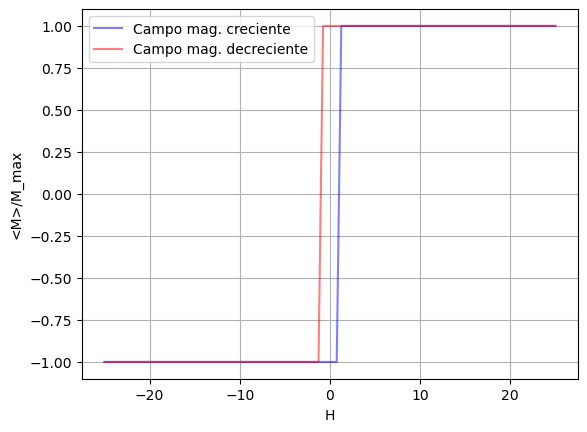

In [35]:
graphHysteresis()